In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1
import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout



In [4]:
data_folder = 'data/'

df = pd.read_csv(data_folder+'NGC2403.curve.02', skiprows=1, sep=' ')
df.columns =['r', 'vrot', 'vdisp', 'verr', 'vapp', 'vrec', 'err', 'pa',
             'incl','vsys']
N = len(df.values)
df.head()

,r,vrot,vdisp,verr,vapp,vrec,err,pa,incl,vsys
0,8.0,15.78,6.32,1.16,25.77,8.24,7.691,125.9,61.5,132.8
1,12.0,22.30,4.10,0.62,26.63,18.43,4.584,125.9,61.5,132.8
2,16.0,32.16,3.90,0.50,37.04,27.73,4.542,125.9,61.5,132.8
3,20.0,39.67,4.06,0.46,43.24,36.12,4.433,125.9,61.5,132.8
4,24.0,46.24,4.31,0.45,50.86,41.60,4.892,125.9,61.5,132.8


In [5]:
N

287

In [7]:
df = df[['r', 'vrot', 'verr']]
df.head()

,r,vrot,verr
0,8.0,15.78,1.16
1,12.0,22.30,0.62
2,16.0,32.16,0.50
3,20.0,39.67,0.46
4,24.0,46.24,0.45


In [8]:
np.min(df['r'].values), np.max(df['r'].values)

(8.0, 1152.0)

No handles with labels found to put in legend.


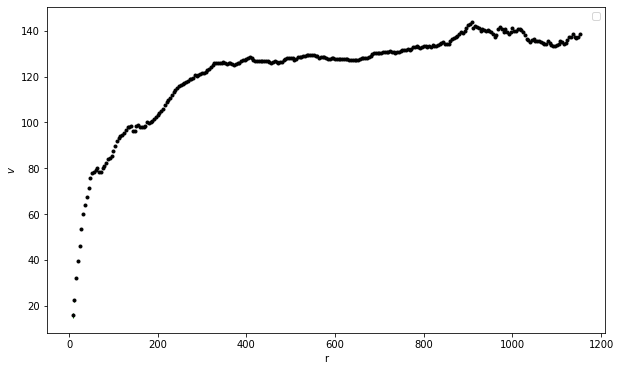

In [10]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(df['r'].values, df['vrot'].values, yerr=df['verr'].values, fmt='.', color='k', elinewidth=1, ecolor='green')
plt.ylabel("$v$")
plt.xlabel("r")
plt.legend()

In [15]:
randomize = np.random.permutation(N)
data = df.values[randomize]

z = data[:,0]
y = data[:,1:]

In [16]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [17]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [18]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((229, 1), (229, 1), (58, 1), (58, 1))

In [19]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0005)


# Compile Keras model
model = model_regression_dropout(num_hidden=[50, 200, 150])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                100       
                                                                 
 MCDropout_1 (MCDropout)     (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 200)               10200     
                                                                 
 MCDropout_2 (MCDropout)     (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 150)               30150     
                                                                 
 MCDropout_3 (MCDropout)     (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 3

In [20]:
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=1000,verbose=1,
                                    validation_data=(z_test, y_test))



Epoch 1/1000
58/58 [==============================] - 1s 4ms/step - loss: 7141.1729 - val_loss: 4590.7134
Epoch 2/1000
58/58 [==============================] - 0s 2ms/step - loss: 1802.2906 - val_loss: 1177.4156
Epoch 3/1000
58/58 [==============================] - 0s 2ms/step - loss: 710.7056 - val_loss: 858.3837
Epoch 4/1000
58/58 [==============================] - 0s 2ms/step - loss: 413.0079 - val_loss: 655.6274
Epoch 5/1000
58/58 [==============================] - 0s 2ms/step - loss: 346.2529 - val_loss: 476.8828
Epoch 6/1000
58/58 [==============================] - 0s 2ms/step - loss: 302.8157 - val_loss: 498.2546
Epoch 7/1000
58/58 [==============================] - 0s 2ms/step - loss: 247.3065 - val_loss: 448.7211
Epoch 8/1000
58/58 [==============================] - 0s 2ms/step - loss: 219.5080 - val_loss: 303.5817
Epoch 9/1000
58/58 [==============================] - 0s 2ms/step - loss: 180.4226 - val_loss: 359.2885
Epoch 10/1000
58/58 [==============================] - 0s 2m

58/58 [==============================] - 0s 2ms/step - loss: 83.8200 - val_loss: 149.7421
Epoch 80/1000
58/58 [==============================] - 0s 2ms/step - loss: 77.7354 - val_loss: 151.8787
Epoch 81/1000
58/58 [==============================] - 0s 2ms/step - loss: 75.6072 - val_loss: 148.2789
Epoch 82/1000
58/58 [==============================] - 0s 2ms/step - loss: 87.6749 - val_loss: 92.3951
Epoch 83/1000
58/58 [==============================] - 0s 2ms/step - loss: 71.4710 - val_loss: 110.8294
Epoch 84/1000
58/58 [==============================] - 0s 2ms/step - loss: 79.0523 - val_loss: 121.0153
Epoch 85/1000
58/58 [==============================] - 0s 2ms/step - loss: 84.9012 - val_loss: 158.5482
Epoch 86/1000
58/58 [==============================] - 0s 2ms/step - loss: 77.6903 - val_loss: 163.8989
Epoch 87/1000
58/58 [==============================] - 0s 2ms/step - loss: 68.0210 - val_loss: 114.1772
Epoch 88/1000
58/58 [==============================] - 0s 2ms/step - loss: 83.8

58/58 [==============================] - 0s 2ms/step - loss: 72.9732 - val_loss: 115.2002
Epoch 158/1000
58/58 [==============================] - 0s 2ms/step - loss: 81.2517 - val_loss: 92.1970
Epoch 159/1000
58/58 [==============================] - 0s 2ms/step - loss: 68.6588 - val_loss: 110.5204
Epoch 160/1000
58/58 [==============================] - 0s 2ms/step - loss: 72.7811 - val_loss: 107.3194
Epoch 161/1000
58/58 [==============================] - 0s 2ms/step - loss: 79.4292 - val_loss: 115.6233
Epoch 162/1000
58/58 [==============================] - 0s 2ms/step - loss: 79.5151 - val_loss: 103.9095
Epoch 163/1000
58/58 [==============================] - 0s 2ms/step - loss: 68.6343 - val_loss: 88.4127
Epoch 164/1000
58/58 [==============================] - 0s 2ms/step - loss: 84.7732 - val_loss: 119.0739
Epoch 165/1000
58/58 [==============================] - 0s 2ms/step - loss: 59.3163 - val_loss: 100.5617
Epoch 166/1000
58/58 [==============================] - 0s 2ms/step - lo

58/58 [==============================] - 0s 2ms/step - loss: 69.2264 - val_loss: 98.9831
Epoch 236/1000
58/58 [==============================] - 0s 2ms/step - loss: 60.6537 - val_loss: 125.4400
Epoch 237/1000
58/58 [==============================] - 0s 2ms/step - loss: 64.3091 - val_loss: 94.5078
Epoch 238/1000
58/58 [==============================] - 0s 2ms/step - loss: 71.9663 - val_loss: 86.8671
Epoch 239/1000
58/58 [==============================] - 0s 2ms/step - loss: 64.8108 - val_loss: 145.6712
Epoch 240/1000
58/58 [==============================] - 0s 2ms/step - loss: 63.1874 - val_loss: 102.0736
Epoch 241/1000
58/58 [==============================] - 0s 2ms/step - loss: 61.0446 - val_loss: 96.1077
Epoch 242/1000
58/58 [==============================] - 0s 2ms/step - loss: 65.3267 - val_loss: 95.0474
Epoch 243/1000
58/58 [==============================] - 0s 2ms/step - loss: 75.6524 - val_loss: 105.9960
Epoch 244/1000
58/58 [==============================] - 0s 2ms/step - loss:

58/58 [==============================] - 0s 2ms/step - loss: 52.8122 - val_loss: 67.0302
Epoch 314/1000
58/58 [==============================] - 0s 2ms/step - loss: 53.9563 - val_loss: 97.4442
Epoch 315/1000
58/58 [==============================] - 0s 2ms/step - loss: 67.8013 - val_loss: 105.0498
Epoch 316/1000
58/58 [==============================] - 0s 2ms/step - loss: 62.0168 - val_loss: 61.6057
Epoch 317/1000
58/58 [==============================] - 0s 2ms/step - loss: 63.2044 - val_loss: 69.6404
Epoch 318/1000
58/58 [==============================] - 0s 2ms/step - loss: 59.3978 - val_loss: 93.1293
Epoch 319/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.4743 - val_loss: 103.2286
Epoch 320/1000
58/58 [==============================] - 0s 2ms/step - loss: 54.3298 - val_loss: 83.1629
Epoch 321/1000
58/58 [==============================] - 0s 2ms/step - loss: 68.5956 - val_loss: 73.4287
Epoch 322/1000
58/58 [==============================] - 0s 2ms/step - loss: 7

Epoch 392/1000
58/58 [==============================] - 0s 3ms/step - loss: 55.9509 - val_loss: 88.5720
Epoch 393/1000
58/58 [==============================] - 0s 3ms/step - loss: 67.1356 - val_loss: 53.8433
Epoch 394/1000
58/58 [==============================] - 0s 2ms/step - loss: 65.6741 - val_loss: 73.0534
Epoch 395/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.2917 - val_loss: 93.4909
Epoch 396/1000
58/58 [==============================] - 0s 2ms/step - loss: 58.3072 - val_loss: 86.7803
Epoch 397/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.2680 - val_loss: 79.3672
Epoch 398/1000
58/58 [==============================] - 0s 2ms/step - loss: 56.8241 - val_loss: 87.1155
Epoch 399/1000
58/58 [==============================] - 0s 2ms/step - loss: 59.0422 - val_loss: 62.7652
Epoch 400/1000
58/58 [==============================] - 0s 3ms/step - loss: 65.0013 - val_loss: 63.9138
Epoch 401/1000
58/58 [==============================] - 0s 3ms/s

58/58 [==============================] - 0s 2ms/step - loss: 58.1900 - val_loss: 55.8664
Epoch 471/1000
58/58 [==============================] - 0s 2ms/step - loss: 69.7464 - val_loss: 78.1001
Epoch 472/1000
58/58 [==============================] - 0s 2ms/step - loss: 62.7191 - val_loss: 75.5952
Epoch 473/1000
58/58 [==============================] - 0s 2ms/step - loss: 56.1552 - val_loss: 90.9067
Epoch 474/1000
58/58 [==============================] - 0s 2ms/step - loss: 60.4293 - val_loss: 70.5316
Epoch 475/1000
58/58 [==============================] - 0s 2ms/step - loss: 53.4521 - val_loss: 71.6003
Epoch 476/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.6811 - val_loss: 78.3575
Epoch 477/1000
58/58 [==============================] - 0s 2ms/step - loss: 67.1651 - val_loss: 63.5283
Epoch 478/1000
58/58 [==============================] - 0s 2ms/step - loss: 52.4438 - val_loss: 74.9201
Epoch 479/1000
58/58 [==============================] - 0s 2ms/step - loss: 64.

Epoch 549/1000
58/58 [==============================] - 0s 2ms/step - loss: 64.6811 - val_loss: 79.5102
Epoch 550/1000
58/58 [==============================] - 0s 2ms/step - loss: 57.8400 - val_loss: 80.2783
Epoch 551/1000
58/58 [==============================] - 0s 2ms/step - loss: 48.7389 - val_loss: 79.3043
Epoch 552/1000
58/58 [==============================] - 0s 2ms/step - loss: 60.8739 - val_loss: 85.9284
Epoch 553/1000
58/58 [==============================] - 0s 2ms/step - loss: 65.4760 - val_loss: 78.9220
Epoch 554/1000
58/58 [==============================] - 0s 2ms/step - loss: 56.8436 - val_loss: 98.3644
Epoch 555/1000
58/58 [==============================] - 0s 2ms/step - loss: 57.2838 - val_loss: 81.4155
Epoch 556/1000
58/58 [==============================] - 0s 2ms/step - loss: 58.3494 - val_loss: 54.4816
Epoch 557/1000
58/58 [==============================] - 0s 2ms/step - loss: 54.1803 - val_loss: 73.7871
Epoch 558/1000
58/58 [==============================] - 0s 2ms/s

58/58 [==============================] - 0s 2ms/step - loss: 48.6364 - val_loss: 69.4056
Epoch 628/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.9581 - val_loss: 46.6079
Epoch 629/1000
58/58 [==============================] - 0s 2ms/step - loss: 61.5170 - val_loss: 86.0678
Epoch 630/1000
58/58 [==============================] - 0s 2ms/step - loss: 46.3617 - val_loss: 71.2782
Epoch 631/1000
58/58 [==============================] - 0s 2ms/step - loss: 49.3753 - val_loss: 64.1301
Epoch 632/1000
58/58 [==============================] - 0s 2ms/step - loss: 64.0616 - val_loss: 67.3072
Epoch 633/1000
58/58 [==============================] - 0s 2ms/step - loss: 51.4341 - val_loss: 90.7785
Epoch 634/1000
58/58 [==============================] - 0s 2ms/step - loss: 57.6892 - val_loss: 60.7435
Epoch 635/1000
58/58 [==============================] - 0s 2ms/step - loss: 52.4690 - val_loss: 104.3499
Epoch 636/1000
58/58 [==============================] - 0s 2ms/step - loss: 54

Epoch 706/1000
58/58 [==============================] - 0s 2ms/step - loss: 59.5713 - val_loss: 55.6758
Epoch 707/1000
58/58 [==============================] - 0s 2ms/step - loss: 51.8657 - val_loss: 75.1021
Epoch 708/1000
58/58 [==============================] - 0s 2ms/step - loss: 60.3906 - val_loss: 92.4679
Epoch 709/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.8009 - val_loss: 68.8463
Epoch 710/1000
58/58 [==============================] - 0s 2ms/step - loss: 54.4354 - val_loss: 58.8151
Epoch 711/1000
58/58 [==============================] - 0s 2ms/step - loss: 54.6398 - val_loss: 81.7923
Epoch 712/1000
58/58 [==============================] - 0s 2ms/step - loss: 52.4099 - val_loss: 51.6003
Epoch 713/1000
58/58 [==============================] - 0s 2ms/step - loss: 56.7122 - val_loss: 63.3887
Epoch 714/1000
58/58 [==============================] - 0s 2ms/step - loss: 52.3560 - val_loss: 68.1055
Epoch 715/1000
58/58 [==============================] - 0s 2ms/s

58/58 [==============================] - 0s 2ms/step - loss: 58.4224 - val_loss: 67.3050
Epoch 785/1000
58/58 [==============================] - 0s 2ms/step - loss: 52.5429 - val_loss: 106.8919
Epoch 786/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.3854 - val_loss: 75.8979
Epoch 787/1000
58/58 [==============================] - 0s 2ms/step - loss: 49.1208 - val_loss: 64.8025
Epoch 788/1000
58/58 [==============================] - 0s 2ms/step - loss: 44.0178 - val_loss: 49.7998
Epoch 789/1000
58/58 [==============================] - 0s 2ms/step - loss: 57.3886 - val_loss: 82.0978
Epoch 790/1000
58/58 [==============================] - 0s 2ms/step - loss: 54.5136 - val_loss: 75.4895
Epoch 791/1000
58/58 [==============================] - 0s 2ms/step - loss: 47.9164 - val_loss: 60.6915
Epoch 792/1000
58/58 [==============================] - 0s 2ms/step - loss: 50.8818 - val_loss: 65.4791
Epoch 793/1000
58/58 [==============================] - 0s 2ms/step - loss: 52

Epoch 863/1000
58/58 [==============================] - 0s 2ms/step - loss: 48.0471 - val_loss: 78.6549
Epoch 864/1000
58/58 [==============================] - 0s 2ms/step - loss: 57.4752 - val_loss: 90.0223
Epoch 865/1000
58/58 [==============================] - 0s 2ms/step - loss: 47.4881 - val_loss: 65.7943
Epoch 866/1000
58/58 [==============================] - 0s 2ms/step - loss: 53.8669 - val_loss: 74.0173
Epoch 867/1000
58/58 [==============================] - 0s 2ms/step - loss: 42.9658 - val_loss: 64.3638
Epoch 868/1000
58/58 [==============================] - 0s 2ms/step - loss: 50.1147 - val_loss: 98.0845
Epoch 869/1000
58/58 [==============================] - 0s 2ms/step - loss: 49.7093 - val_loss: 90.6834
Epoch 870/1000
58/58 [==============================] - 0s 2ms/step - loss: 51.8877 - val_loss: 87.0939
Epoch 871/1000
58/58 [==============================] - 0s 2ms/step - loss: 53.0791 - val_loss: 81.5029
Epoch 872/1000
58/58 [==============================] - 0s 2ms/s

58/58 [==============================] - 0s 2ms/step - loss: 56.5213 - val_loss: 54.2075
Epoch 942/1000
58/58 [==============================] - 0s 2ms/step - loss: 49.9452 - val_loss: 83.6995
Epoch 943/1000
58/58 [==============================] - 0s 2ms/step - loss: 42.0739 - val_loss: 62.9160
Epoch 944/1000
58/58 [==============================] - 0s 2ms/step - loss: 49.3958 - val_loss: 89.6848
Epoch 945/1000
58/58 [==============================] - 0s 2ms/step - loss: 56.8685 - val_loss: 81.8695
Epoch 946/1000
58/58 [==============================] - 0s 2ms/step - loss: 50.3760 - val_loss: 79.9313
Epoch 947/1000
58/58 [==============================] - 0s 2ms/step - loss: 52.9763 - val_loss: 89.7220
Epoch 948/1000
58/58 [==============================] - 0s 2ms/step - loss: 55.1890 - val_loss: 85.1064
Epoch 949/1000
58/58 [==============================] - 0s 2ms/step - loss: 51.2885 - val_loss: 59.8878
Epoch 950/1000
58/58 [==============================] - 0s 2ms/step - loss: 44.

In [21]:
model_train.history['val_loss'][-1]

88.05604553222656

In [22]:


# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(3, 1150, test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



32/32 [==============================] - 0s 1ms/step


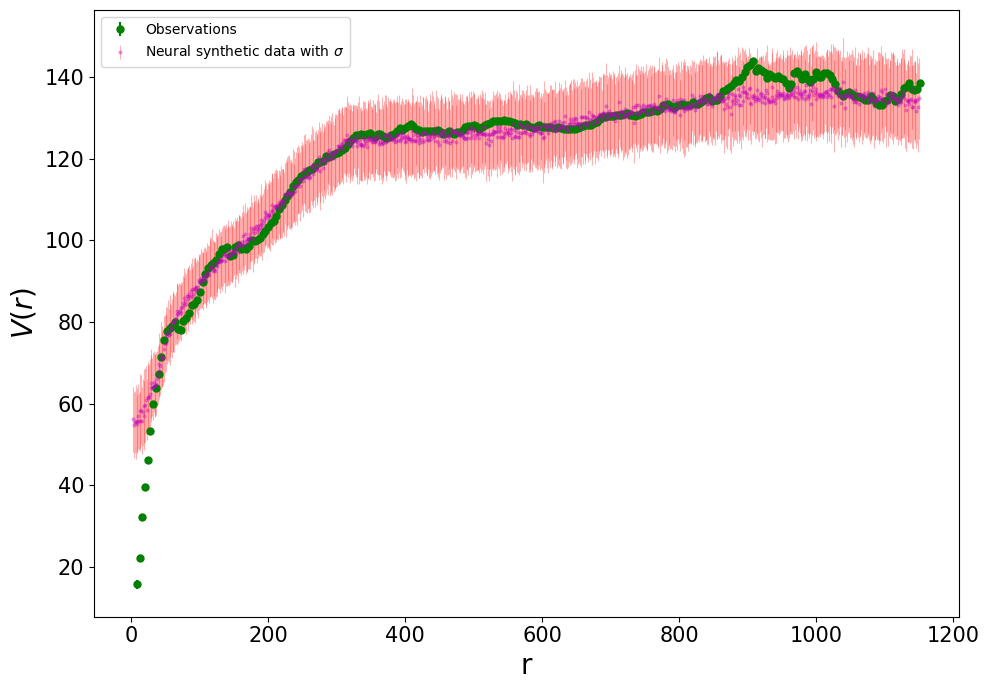

In [24]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
# plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df['r'].values, df['vrot'].values, yerr=df['verr'].values, fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Neural synthetic data with $\sigma$')


# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$V(r)$", fontsize=20)
plt.xlabel("r", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("neural_reconstruction_RC.png", dpi=100)

In [ ]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 100)